In [1]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun, hbar
import astropy.units as u
from scipy.optimize import fsolve


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Dimensionless

$$

p'' = \frac{p}{m_f^4} \qquad \epsilon'' = \frac{\epsilon}{m_f^4}  \qquad  M'' =  \frac{M}{a} \qquad R'' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$
$$

p' =p'' \frac{m_f^4}{4B} \qquad \epsilon' = \epsilon''\frac{m_f^4}{4B}
$$

# Quark matter


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

Dimensionless

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$
$$
p' = \frac{1}{3}(\epsilon' - 1)
$$


In [3]:
# open a data file
data = pd.read_csv('../Data/EOS_QM.csv')

# Extract columns
grid_e_quark = data['e']
grid_p_quark = data['p']


data = pd.read_csv('../Data/EOS_DM.csv')

# Extract columns
grid_e_dm = data['e']
grid_p_dm = data['p']

Two fluid

In [124]:
def compute_two_fluid_properties(e_quark, p_quark, e_dm, p_dm, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    p_quark_c = np.interp(central_e_quark_phys, grid_e_quark, grid_p_quark)
    m_quark_c = (4/3) * np.pi * r0**3 * central_e_quark_phys
    
    # Dark Matter ICs
    p_dm_c = np.interp(central_e_dm_phys, list_e_DM, list_p_DM)
    m_dm_c = (4/3) * np.pi * r0**3 * central_e_dm_phys
    
    x0 = [p_quark_c, m_quark_c, p_dm_c, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, list_p_quark, list_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, list_p_DM, list_e_DM)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = 0.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = 0.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # 3. Events
    # ---------
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = True
    event_Quark_surface.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_DM_surface, event_Quark_surface],
        rtol=1e-8, 
        atol=1e-10,
        max_step=1e-4,   # Critical for DM core resolution
        first_step=1e-7
    )

    # 5. Extract "Last Positive Pressure" Values
    # ------------------------------------------
    r_adim = sol.t
    p1_adim = sol.y[0]
    m1_adim = sol.y[1]
    p2_adim = sol.y[2]
    m2_adim = sol.y[3]

    # --- Quark Results ---
    idx_q_valid = np.where(p1_adim > 0)[0]
    if len(idx_q_valid) > 0:
        last_q = idx_q_valid[-1]
        R_quark_adim = r_adim[last_q]
        M_quark_adim = m1_adim[last_q]
    else:
        R_quark_adim = 0.0
        M_quark_adim = 0.0

    # --- Dark Matter Results ---
    idx_dm_valid = np.where(p2_adim > 0)[0]
    if len(idx_dm_valid) > 0:
        last_dm = idx_dm_valid[-1]
        R_dm_adim = r_adim[last_dm]
        M_dm_adim = m2_adim[last_dm]
    else:
        R_dm_adim = 0.0
        M_dm_adim = 0.0

    # 6. Physical Conversions
    # -----------------------

    factor_R_to_km = (M_p.value / (2 * np.sqrt(B))) * hc * 1e-18
    factor_M_to_Solar = (M_p.value **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg

    M_total_sol = (M_quark_adim + M_dm_adim) * factor_M_to_Solar
    R_total_km = max(R_quark_adim, R_dm_adim) * factor_R_to_km
    quark_mass = M_quark_adim * factor_M_to_Solar
    dm_mass = M_dm_adim * factor_M_to_Solar

    results = {
        "R_quark_km": R_quark_adim * factor_R_to_km,
        "M_quark_sol": M_quark_adim * factor_M_to_Solar,
        "R_dm_km": R_dm_adim * factor_R_to_km,
        "M_dm_sol": M_dm_adim * factor_M_to_Solar,
        "R_total_km": max(R_quark_adim, R_dm_adim) * factor_R_to_km,
        "M_total_sol": (M_quark_adim + M_dm_adim) * factor_M_to_Solar
    }
    return results, M_total_sol , R_total_km, quark_mass, dm_mass, 



In [125]:
e_quark_central = 1000 * hc**3 / (4 * B) 
e_dm_central    = 3e6 * hc**3 / (4 * B) 


data, _, _, _, _ = compute_two_fluid_properties(e_quark_central, e_dm_central)

print(f"Quark Star: R = {data['R_quark_km']:.4f} km, M = {data['M_quark_sol']:.4f} M_sun")
print(f"DM Core:    R = {data['R_dm_km']:.4f} km, M = {data['M_dm_sol']:.4f} M_sun")

Quark Star: R = 11.0543 km, M = 2.0020 M_sun
DM Core:    R = 0.0069 km, M = 0.0000 M_sun


In [126]:
central_energy_densities_phys = np.linspace(250,2500,100) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 

e_dm_central    = 3e6 * hc**3 / (4 * B) 

list_R = []
list_M = []
list_quark_mass = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)


   

In [127]:
e_dm_central = 3e10 * hc**3 / (4 * B) 

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)

In [128]:
e_dm_central = 3e9 * hc**3 / (4 * B) 

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)

In [129]:

list_M_3e6 = list_quark_mass[:100]
list_M_3e10 = list_quark_mass[100:200]
list_M_3e9 = list_quark_mass[200:300]

list_R_3e6 = list_R[:100]
list_R_3e10 = list_R[100:200]
list_R_3e9 = list_R[200:300]

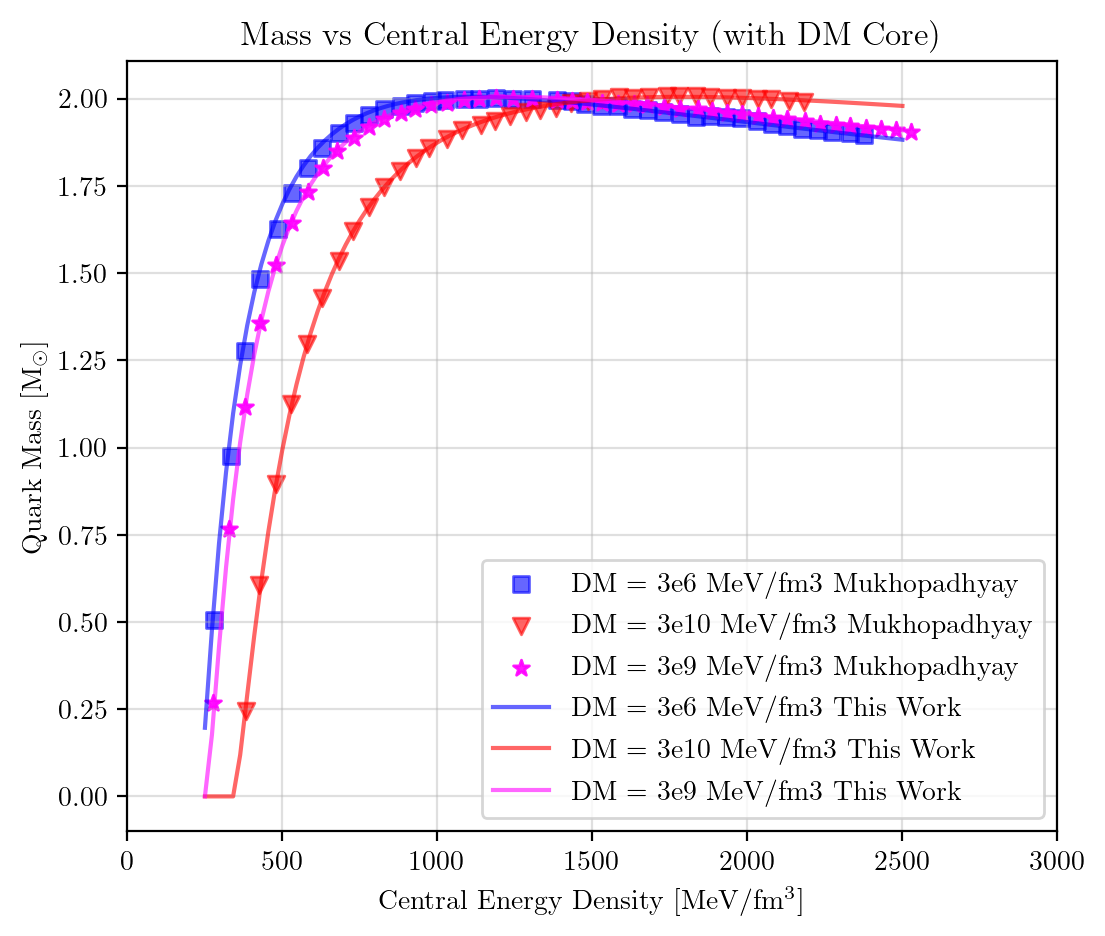

Maximum Quark Mass with DM 3e6 MeV/fm3:  2.00528 M_sun at Central Energy Density: 1113.64 MeV/fm^3
Maximum Quark Mass with DM 3e9 MeV/fm3:  2.00522 M_sun at Central Energy Density: 1250.00 MeV/fm^3
Maximum Quark Mass with DM 3e10 MeV/fm3: 2.00515 M_sun at Central Energy Density: 1795.45 MeV/fm^3


In [139]:

plt.figure(figsize=(6,5))

data = pd.read_csv('../Data/two_fluids_dm3e6.csv')
plt.scatter(data['x'], data[' y'], color='blue', label='DM = 3e6 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='s')

data = pd.read_csv('../Data/two_fluids_dm3e10.csv')
plt.scatter(data['x'], data[' y'], color='red', label='DM = 3e10 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='v')

data = pd.read_csv('../Data/twofluids_dm3e9.csv')
plt.scatter(data['x'], data[' y'], color='fuchsia', label='DM = 3e9 MeV/fm3 Mukhopadhyay', alpha=0.9, marker='*')

plt.plot(central_energy_densities_phys, list_M_3e6, color='blue', alpha=0.6, label='DM = 3e6 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, list_M_3e10, color='red', alpha=0.6, label='DM = 3e10 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, list_M_3e9, color='fuchsia', alpha=0.6, label='DM = 3e9 MeV/fm3 This Work')

plt.xlabel("Central Energy Density [MeV/fm$^3$]")
plt.xlim(0,3000)
plt.ylabel("Quark Mass [M$_\odot$]")
plt.title("Mass vs Central Energy Density (with DM Core)")
plt.legend()
plt.grid()
plt.show()


# print maximum masses and corresponding central energy densities
max_M_3e6 = max(list_M_3e6)
idx_max_3e6 = list_M_3e6.index(max_M_3e6)
corresponding_e_3e6 = central_energy_densities_phys[idx_max_3e6]    
print(f"Maximum Quark Mass with DM 3e6 MeV/fm3:  {max_M_3e6:.5f} M_sun at Central Energy Density: {corresponding_e_3e6:.2f} MeV/fm^3")

max_M_3e9 = max(list_M_3e9)
idx_max_3e9 = list_M_3e9.index(max_M_3e9)
corresponding_e_3e9 = central_energy_densities_phys[idx_max_3e9]    
print(f"Maximum Quark Mass with DM 3e9 MeV/fm3:  {max_M_3e9:.5f} M_sun at Central Energy Density: {corresponding_e_3e9:.2f} MeV/fm^3")

max_M_3e10 = max(list_M_3e10)
idx_max_3e10 = list_M_3e10.index(max_M_3e10)
corresponding_e_3e10 = central_energy_densities_phys[idx_max_3e10]    
print(f"Maximum Quark Mass with DM 3e10 MeV/fm3: {max_M_3e10:.5f} M_sun at Central Energy Density: {corresponding_e_3e10:.2f} MeV/fm^3")



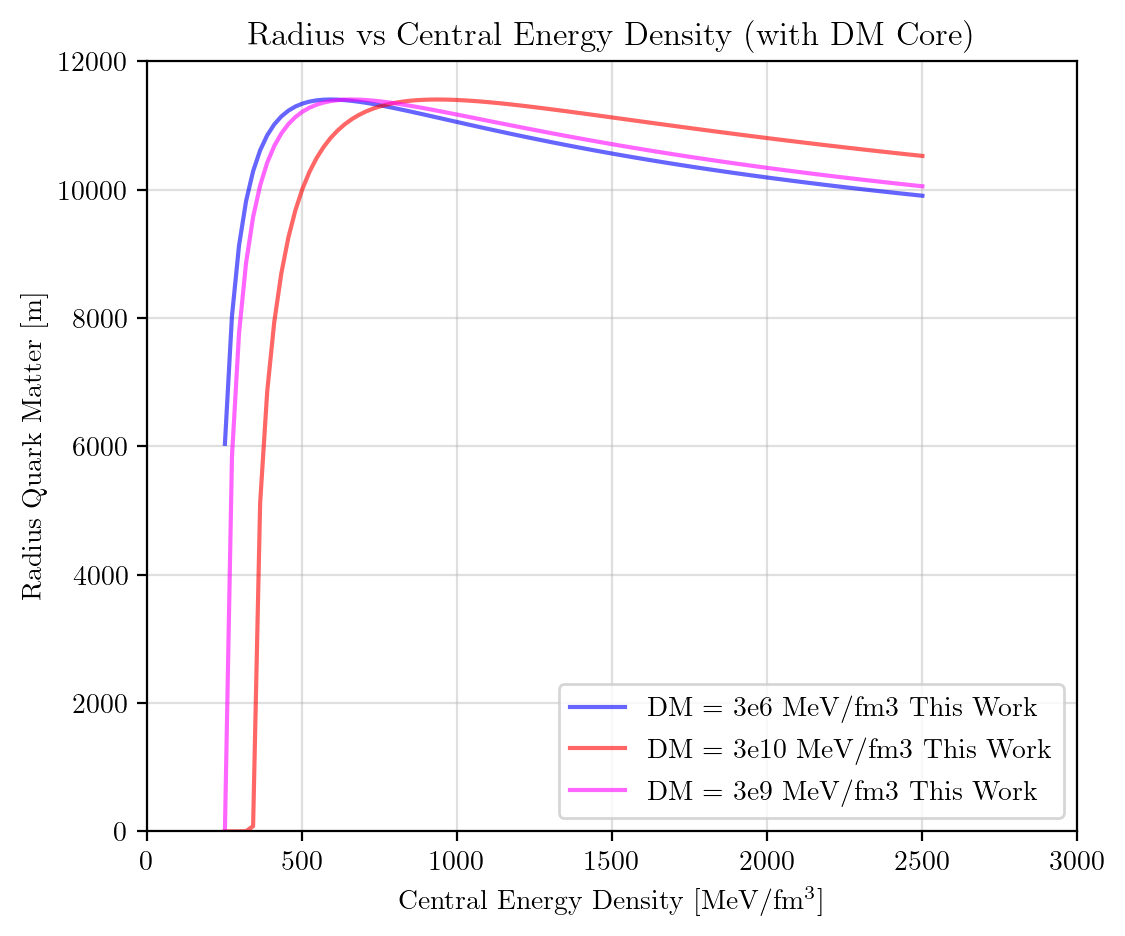

In [131]:
plt.figure(figsize=(6,5))

plt.plot(central_energy_densities_phys, np.array(list_R_3e6) * 1000, color='blue', alpha=0.6, label='DM = 3e6 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, np.array(list_R_3e10) * 1000, color='red', alpha=0.6, label='DM = 3e10 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, np.array(list_R_3e9) * 1000, color='fuchsia', alpha=0.6, label='DM = 3e9 MeV/fm3 This Work')

plt.xlabel("Central Energy Density [MeV/fm$^3$]")
plt.xlim(0,3000)
plt.ylim(0,12000)
plt.ylabel("Radius Quark Matter [m]")
plt.title("Radius vs Central Energy Density (with DM Core)")
plt.legend()
plt.grid()
plt.show()


In [132]:
q_central_energy_density = 600 * hc**3 / (4 * B) 

dm_central_energy_densities_phys = np.linspace(1e10, 4e11,50) 

central_energy_densities = dm_central_energy_densities_phys * hc**3 / (4 * B)


list_R_DM = []
list_DM_mass = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    results, _, _, _, Mdm = compute_two_fluid_properties(q_central_energy_density, e_central)
    list_R_DM.append(results['R_dm_km'])
    list_DM_mass.append(Mdm)


   

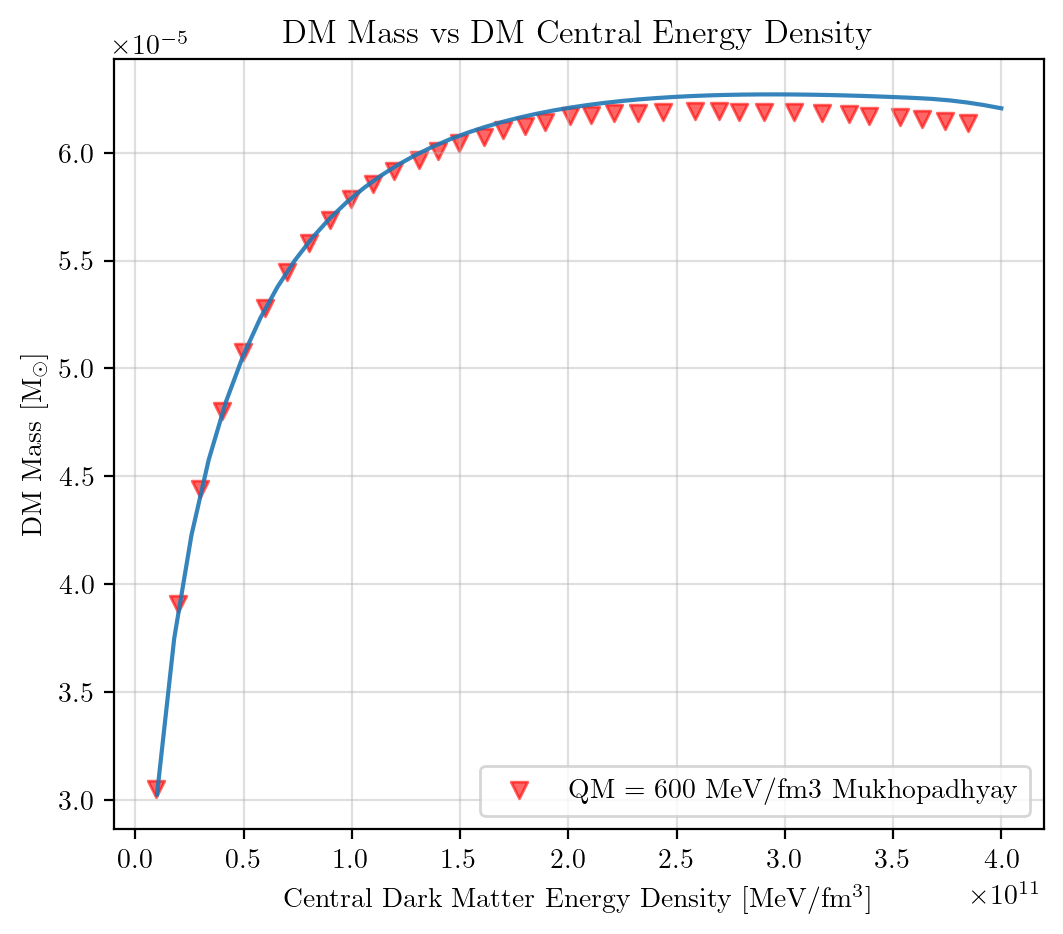

In [133]:
plt.figure(figsize=(6,5))
plt.plot(dm_central_energy_densities_phys, list_DM_mass, color='tab:blue', alpha=0.9)

data = pd.read_csv('../Data/twofluids_dm.csv')
plt.scatter(data['x'], data[' y'], color='red', label='QM = 600 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='v')

plt.xlabel("Central Dark Matter Energy Density [MeV/fm$^3$]")
plt.ylabel("DM Mass [M$_\odot$]")
plt.title("DM Mass vs DM Central Energy Density")
plt.grid()
plt.legend()
plt.show()


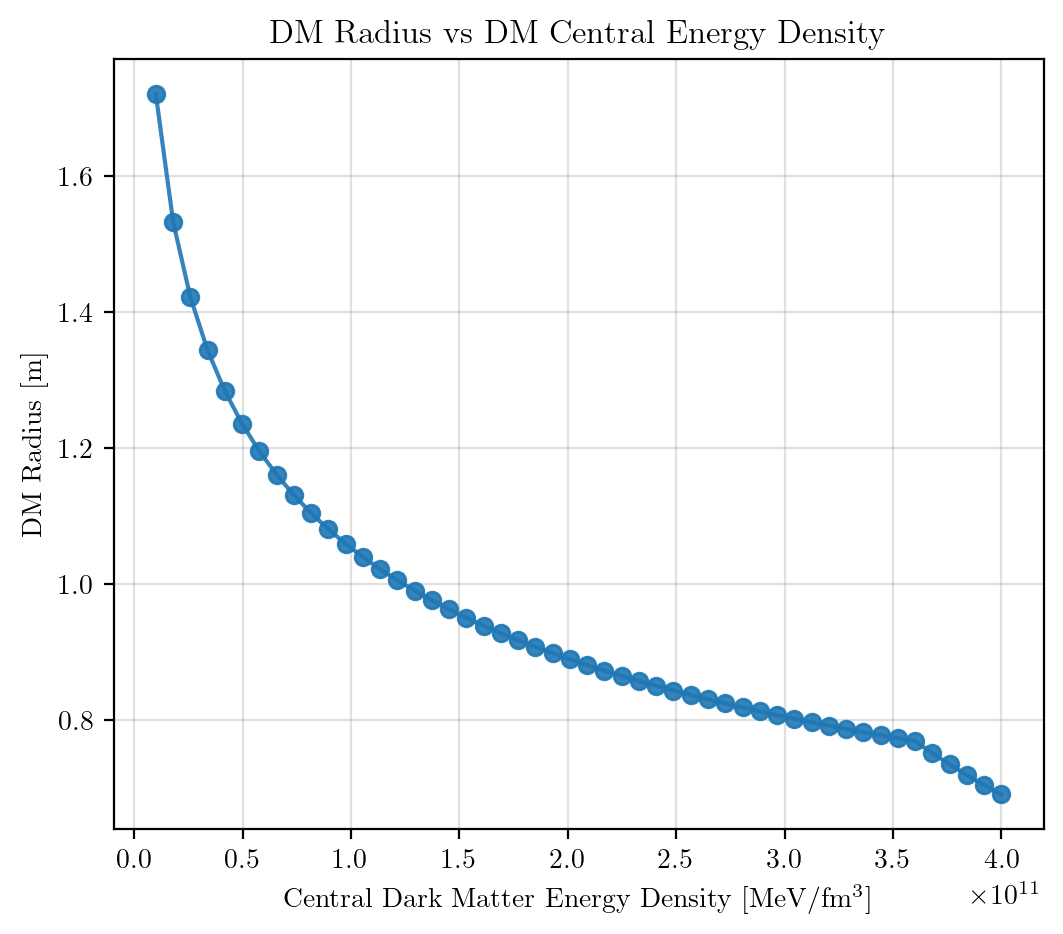

In [135]:
plt.figure(figsize=(6,5))
plt.plot(dm_central_energy_densities_phys, np.array(list_R_DM)*1000, color='tab:blue', alpha=0.9, marker='o')
plt.xlabel("Central Dark Matter Energy Density [MeV/fm$^3$]")
plt.ylabel("DM Radius [m]")
plt.title("DM Radius vs DM Central Energy Density")
plt.grid()
plt.show()